# Generate the heirarchy of morphotopes

This notebooks combines the original data with those from the extension and generates a completely fresh taxonomy. Note that this is not what is released. The released product assigns morphotopes from the extension to the existing tree.

In [41]:
import numpy as np
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import StandardScaler
from core.cluster_validation import get_linkage_matrix
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster

In [2]:
regions_datadir = "/data/uscuni-ulce/"
region_hulls = gpd.read_parquet(
    regions_datadir + "regions/" + "region_hulls_v3.parquet"
)

In [3]:
v = "v10_ext1"

In [4]:
model_params = "_post_processing_v1"

In [5]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = "/data/uscuni-ulce/processed_data/morphotopes/"

# model_params = '_75_0_None_None_False'


clip = None
to_drop = [
    "stcSAl",
    "stbOri",
    "stcOri",
    "stbCeA",
    "ldkAre",
    "ldkPer",
    "lskCCo",
    "lskERI",
    "lskCWA",
    "ltkOri",
    "ltkWNB",
    "likWBB",
    "likWCe",
    "licBAD",
    "misBAD",
    "ssbCCM",
    "ssbCCD",
]


linkage = "ward"
metric = "euclidean"

morphotope_stat_columns = ["percentile_25", "percentile_75", "mean", "std"]

In [39]:
def preprocess_data(data, scalar, drop_columns=morphotope_stat_columns):
    component_data = data.drop(columns=drop_columns, level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns = component_data.columns.get_level_values(0)

    component_data = component_data[component_data.index.str[-2:] != "-1"]

    vals = scalar.fit_transform(component_data)
    component_data = pd.DataFrame(
        vals, columns=component_data.columns, index=component_data.index
    )
    component_data = component_data.drop(
        component_data.columns[component_data.std() == 0], axis=1
    )

    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(
        vals, columns=component_data.columns, index=component_data.index
    )
    return component_data


def read_region_morphotope_data(region_id, scalar, read_extra=False):
    print("processing", region_id)
    data = pd.read_parquet(
        f"{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq"
    )

    data.index = str(region_id) + "_" + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data, scalar)

    if read_extra:
        extra_chars = pd.read_parquet(f"{morphotopes_dir}morph_chars_{region_id}.pq")
        vals = scalar.fit_transform(extra_chars)
        extra_chars = pd.DataFrame(
            vals, columns=extra_chars.columns, index=extra_chars.index
        ).fillna(0)
        extra_chars = extra_chars.drop(
            component_data.columns[component_data.std() == 0], axis=1
        )
        extra_chars = extra_chars[["limLPS"]]
        extra_chars["limLPS2"] = extra_chars["limLPS"]

        merged_data = pd.merge(
            component_data, extra_chars, how="inner", left_index=True, right_index=True
        )
        pd.testing.assert_index_equal(merged_data.index, component_data.index)
        component_data = merged_data

    return component_data


def get_morphotope_linkage(region_data):
    clusterer = AgglomerativeClustering(
        linkage=linkage, metric=metric, compute_full_tree=True, compute_distances=True
    )
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def read_morphotopes_data(model_params):
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(
            f"{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq"
        )
        region_morphotope_data.index = (
            str(region_id) + "_" + region_morphotope_data.index.str[:]
        )
        data.append(region_morphotope_data)

    data = pd.concat(data)
    return data


def read_morphotopes_chars():
    data = []
    for region_id, _ in region_hulls.iterrows():
        extra_chars = pd.read_parquet(f"{morphotopes_dir}morph_chars_{region_id}.pq")
        data.append(extra_chars)

    data = pd.concat(data)
    return data


def morphotopes_to_etcs(region_id, etcs=True, model_params="_100_0_None_None_False"):
    if etcs:
        etcs = gpd.read_parquet(
            f"/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet"
        )

    else:
        etcs = gpd.read_parquet(
            f"/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet"
        )

    etcs["label"] = -1

    morphotopes = pd.read_parquet(
        f"/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq"
    )
    morphotopes.loc[:, "morphotope_label"] = morphotopes.values[:, 0]

    morphotopes = morphotopes.drop([i for i in morphotopes.index if i not in etcs.index])

    morph_dict = pd.Series(
        np.arange(np.unique(morphotopes.values).shape[0]), np.unique(morphotopes.values)
    )
    etcs.loc[morphotopes.index, "label"] = morphotopes.map(
        lambda x: morph_dict.loc[x]
    ).values
    etcs["morph"] = str(region_id) + "_" + "-1"
    etcs.loc[morphotopes.index, "morph"] = str(region_id) + "_" + morphotopes.values
    return etcs

### Direct morphotope hierarchy

In [7]:
%%time
# read morphotopes data
morphotopes_data = read_morphotopes_data(model_params)
morphotopes_data = morphotopes_data[~morphotopes_data.index.str.endswith("-1")]
morphotopes_data = morphotopes_data.iloc[:, :-1]

## drop unwanted columns
component_data = morphotopes_data.drop(columns=morphotope_stat_columns, level=1)
component_data = component_data.drop(columns=to_drop, level=0)
component_data.columns = component_data.columns.get_level_values(0)

CPU times: user 46.2 s, sys: 49.5 s, total: 1min 35s
Wall time: 43.3 s


In [8]:
# add morphotope variables
morph_chars_data = read_morphotopes_chars()
morph_chars_data = morph_chars_data[["limLPS", "limAre", "limPer"]]
merged_data = pd.merge(
    component_data, morph_chars_data, how="inner", left_index=True, right_index=True
)
pd.testing.assert_index_equal(merged_data.index, component_data.index)
component_data = merged_data

In [9]:
grouped_data = component_data

In [10]:
## Drop massive outliers
grouped_data = grouped_data.drop(
    grouped_data[
        (grouped_data["limAre"] > 5e5)
        | (grouped_data["limPer"] > 2e5)
        | (grouped_data["ldbPWL"] > 5_000)
        | (grouped_data.sdbAre < 20)
    ].index
)

In [11]:
# drop columns
grouped_data = grouped_data.drop(["ssbCor", "mtdDeg", "limPer", "mtbSWR"], axis=1)

In [12]:
scalar = StandardScaler()
vals = scalar.fit_transform(grouped_data)
vals = np.nan_to_num(vals, 0)
regional_ward_morphotopes_data = pd.DataFrame(
    vals, index=grouped_data.index, columns=grouped_data.columns
)

#### Full linkage with graph

In [13]:
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors._base import _kneighbors_from_graph

In [14]:
n_neighbors = 10

In [15]:
%%time

# generate knn graph
graph = kneighbors_graph(
    regional_ward_morphotopes_data.values,
    n_neighbors=n_neighbors,
    n_jobs=-1,
    include_self=True,
    mode="distance",
)
dists, nns = _kneighbors_from_graph(graph, n_neighbors, return_distance=True)

CPU times: user 41min 3s, sys: 757 ms, total: 41min 4s
Wall time: 3min 28s


In [16]:
emgraph = graph
embedding = regional_ward_morphotopes_data

In [17]:
%%time

linkage = "ward"
metric = "euclidean"

clusterer = AgglomerativeClustering(
    linkage=linkage,
    metric=metric,
    connectivity=emgraph,
    compute_full_tree=True,
    compute_distances=True,
)
clusterer.fit(embedding)

/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:325: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


CPU times: user 4min 37s, sys: 1.93 s, total: 4min 39s
Wall time: 4min 35s


AgglomerativeClustering(compute_distances=True, compute_full_tree=True,
                        connectivity=<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9936430 stored elements and shape (993643, 993643)>)

In [18]:
linkage_matrix = get_linkage_matrix(clusterer)

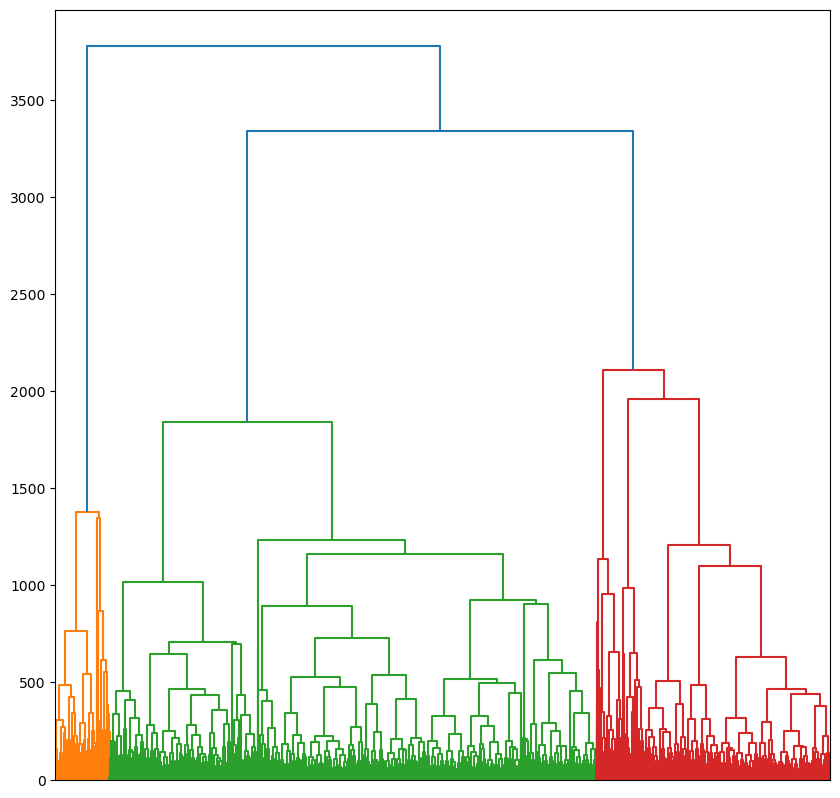

In [19]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

fig, ax = plt.subplots(figsize=(10, 10))
_ = dendrogram(linkage_matrix, ax=ax, no_labels=True)

## Save data

In [20]:
# potentially pick a new cutoff
final_cutoff = 200
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion="distance")
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
final_clusters.value_counts()

75     31167
173    25785
91     22683
166    21226
74     20666
       ...  
109        3
64         3
110        2
34         1
65         1
Name: count, Length: 176, dtype: int64

In [21]:
cdata = grouped_data.groupby(final_clusters).median().fillna(0)
cdata

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbSqu,ssbERI,ssbElo,libNCo,ldbPWL,ltcBuA,...,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limAre
1,68.797955,36.448185,0.0,0.498480,2.445357,0.992028,0.612460,0.0,401.080156,0.400000,...,0.499878,0.418811,0.260032,96.070597,3.922058,3.922058,63.438361,73.193690,1.0,10982.642648
2,95.138955,45.149416,0.0,0.456525,4.578622,0.946462,0.598814,1.0,323.577222,0.400000,...,0.529633,0.460050,0.300754,85.735293,4.185484,4.185484,80.044698,76.926078,1.0,14060.230362
3,155.434172,60.356708,0.0,0.424147,2.094540,0.881573,0.615635,0.0,314.067855,0.555556,...,0.462907,0.476276,0.255892,82.939253,3.628501,3.628501,100.749472,110.619261,1.0,16785.701186
4,83.872749,44.259915,0.0,0.390087,1.616057,0.959765,0.422816,0.0,300.044822,0.500000,...,0.437851,0.541522,0.257721,81.806209,4.150048,4.150048,54.512699,75.965641,1.0,11252.566036
5,93.018292,45.034009,0.0,0.440073,2.629385,0.959672,0.529511,1.0,496.755580,0.400000,...,0.492460,0.403596,0.247540,119.731133,4.457701,4.457701,91.011168,99.534364,1.0,16260.343406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,76.111290,37.223138,0.0,0.555453,0.289586,0.999369,0.697621,0.0,59.933201,0.800000,...,0.674381,0.928831,0.495299,20.864974,2.755845,2.755845,69.934770,80.361925,1.0,5750.484030
173,93.699588,41.282920,0.0,0.540105,1.019401,0.997309,0.669519,0.0,50.991835,0.875000,...,0.674208,0.973434,0.530106,17.946929,2.616669,2.616669,68.021972,75.786008,1.0,4748.966312
174,131.242164,50.778979,0.0,0.512791,0.406898,0.998347,0.606911,0.0,81.291032,0.800000,...,0.599937,0.937177,0.463838,28.904747,3.370682,3.370682,255.442270,276.692921,1.0,21731.343597
175,110.020013,45.558536,0.0,0.525291,1.232409,0.968997,0.681528,0.0,55.513147,0.894444,...,0.687502,0.944455,0.519748,19.407650,2.721798,2.721798,75.624410,77.328085,1.0,4769.423364


In [22]:
normalised_cdata = (
    regional_ward_morphotopes_data.groupby(final_clusters).median().fillna(0)
)
normalised_cdata

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbSqu,ssbERI,ssbElo,libNCo,ldbPWL,ltcBuA,...,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limAre
1,-0.353302,-0.316741,-0.003279,-0.715537,0.792153,0.256496,-0.573057,-0.143897,2.234270,-2.050148,...,-1.031525,-2.825906,-2.034632,2.082641,0.954867,0.954867,-0.151090,-0.176829,0.158167,0.146833
2,0.122055,0.485765,-0.003279,-1.667017,2.110387,-1.543116,-0.737111,0.384656,1.657612,-2.050148,...,-0.788534,-2.567878,-1.621958,1.748950,1.220739,1.220739,-0.076950,-0.161157,0.158167,0.356496
3,1.210160,1.888318,-0.003279,-2.401292,0.575368,-4.105868,-0.534886,-0.143897,1.586858,-1.174549,...,-1.333433,-2.466357,-2.076587,1.658675,0.658583,0.658583,0.015488,-0.019684,0.158167,0.542171
4,-0.081258,0.403727,-0.003279,-3.173719,0.279693,-1.017683,-2.853080,-0.143897,1.482520,-1.487263,...,-1.538053,-2.058126,-2.058054,1.622093,1.184974,1.184974,-0.190939,-0.165190,0.158167,0.165222
5,0.083785,0.475121,-0.003279,-2.040135,0.905871,-1.021364,-1.570323,0.384656,2.946141,-2.050148,...,-1.092099,-2.921104,-2.161225,2.846558,1.495484,1.495484,-0.027989,-0.066228,0.158167,0.506380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,-0.221324,-0.245268,-0.003279,0.576521,-0.539989,0.546425,0.450812,-0.143897,-0.304024,0.201392,...,0.393525,0.365205,0.349571,-0.345489,-0.222176,-0.222176,-0.122086,-0.146731,0.158167,-0.209612
173,0.096080,0.129162,-0.003279,0.228439,-0.089005,0.465098,0.112947,-0.143897,-0.370552,0.623556,...,0.392109,0.644280,0.702312,-0.439703,-0.362645,-0.362645,-0.130626,-0.165944,0.158167,-0.277842
174,0.773584,1.004974,-0.003279,-0.391003,-0.467496,0.506069,-0.639765,-0.143897,-0.145111,0.201392,...,-0.214413,0.417421,0.030751,-0.085913,0.398370,0.398370,0.706124,0.677639,0.158167,0.879097
175,0.390603,0.523497,-0.003279,-0.107507,0.042621,-0.653073,0.257332,-0.143897,-0.336911,0.733006,...,0.500671,0.462963,0.597345,-0.392541,-0.256539,-0.256539,-0.096684,-0.159469,0.158167,-0.276448


In [23]:
# regional_clusters.to_frame().to_parquet(f'/data/uscuni-ulce/processed_data/clusters/regional_clusters_{v}.pq')

In [24]:
final_clusters.to_frame().to_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/final_clusters_{v}.pq"
)

In [25]:
cdata.to_parquet(f"/data/uscuni-ulce/processed_data/clusters/cdata_{v}.pq")

In [26]:
normalised_cdata.to_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/normalised_cdata_{v}.pq"
)

In [27]:
regional_ward_morphotopes_data.to_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_input_data_{v}.pq"
)

In [28]:
np.save(
    f"/data/uscuni-ulce/processed_data/clusters/complete_linkage_{n_neighbors}_{v}.npy",
    linkage_matrix,
)

# Create mapping

In [29]:
## hierarchical cutoff

cutoffs = [200, 300, 500, 700, 1000, 1600, 2500]

cluster_frame = []
for c in reversed(cutoffs):
    clusters = fcluster(linkage_matrix, t=c, criterion="distance")
    cluster_frame.append(pd.Series(clusters, regional_ward_morphotopes_data.index))
cluster_frame = pd.concat(cluster_frame, axis=1)
cluster_frame.columns = cluster_frame.columns + 1

cluster_frame.drop_duplicates().set_index(7).sort_index().to_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq"
)

/home/martin/dev/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pandas/io/parquet.py:480: UserWarning: The DataFrame has non-str index name `[7]` which will be converted to string and not roundtrip correctly.
  impl.write(


## Assign clusters to ETCs in all regions

In [30]:
merged_clusters = pd.read_parquet(
    f"/data/uscuni-ulce/processed_data/clusters/final_clusters_{v}.pq"
)[0]
merged_clusters.nunique()

176

In [40]:
%%time

# morphotope code
for region_id, _ in region_hulls.iterrows():
    print(region_id)
    etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)
    etcs["final"] = etcs["morph"].map(
        lambda x: final_clusters.loc[x]
        if x in regional_ward_morphotopes_data.index
        else -1
    )
    etcs.to_parquet(
        f"/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq"
    )

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677
